# Summary:

This notebook explores the volatility characteristics of the S&P500 index returns using a GARCH(1, 1) model. The GARCH model allows us to analyze the presence of volatility clustering (ARCH effect) and volatility persistence (GARCH effect) in the index returns.

By fitting the GARCH(1, 1) model to the S&P500 index data, we estimate the model parameters, including mu (mean), omega (constant variance), alpha[1] (ARCH coefficient), and beta[1] (GARCH coefficient). These parameters provide insights into the mean level, baseline volatility, and the impact of past squared residuals and conditional variances on current volatility.

The results indicate that the S&P500 index returns exhibit volatility clustering, suggesting that shocks or large price movements tend to cluster together. Additionally, volatility persistence is observed, indicating that past volatility has a persistent effect on future volatility in the index returns. These findings imply that traditional models assuming constant volatility may not accurately capture the characteristics of the S&P500 index, highlighting the importance of incorporating autoregressive and conditional heteroscedastic properties in volatility modeling.

By understanding the volatility patterns in the S&P500 index returns, we can enhance our risk assessments and develop more accurate volatility forecasts.

[*********************100%***********************]  1 of 1 completed


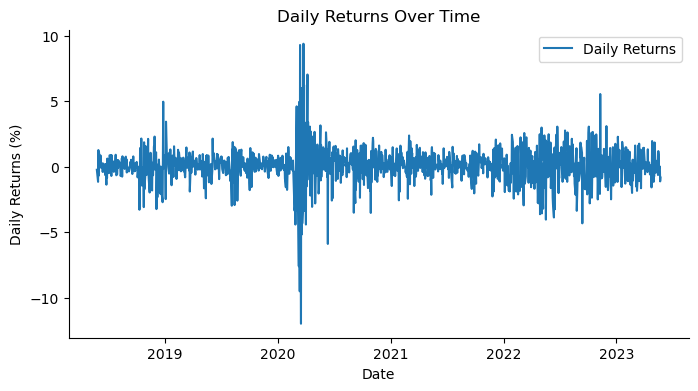

╒════════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│        │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞════════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ S&P500 │         1.37         │          6.27          │         21.72         │
╘════════╧══════════════════════╧════════════════════════╧═══════════════════════╛
mu          0.091856
omega       0.045736
alpha[1]    0.197099
beta[1]     0.784570
Name: params, dtype: float64


                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2023-05-24  0.825534  0.856137  0.886179  0.915671  0.944622


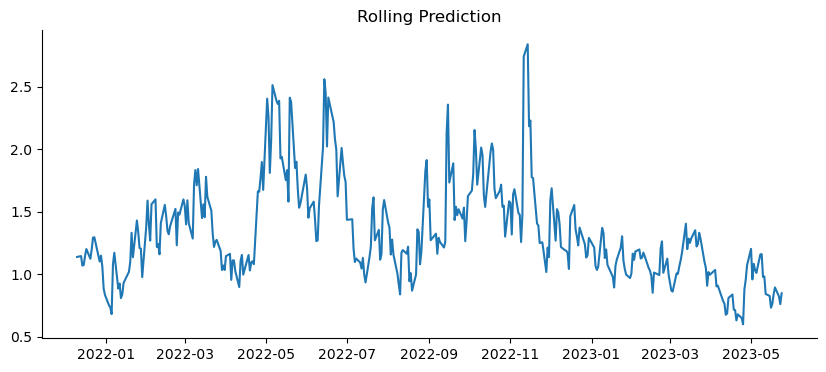

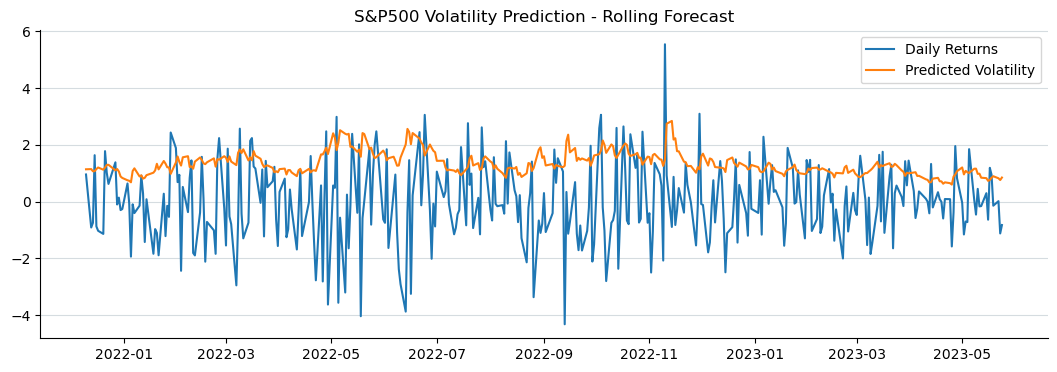

In [1]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Downloading stock data for the S&P500 index for the last 5 years
ticker = "^GSPC"
stock_data = yf.download(ticker, period='5y')

# Calculating daily returns and adding as a new column in the DataFrame
stock_data['Daily_Return'] = 100 * (stock_data['Close'].pct_change())

# Dropping rows with missing values
stock_data.dropna(inplace=True)

# Plotting the daily returns over time
fig, ax = plt.subplots(figsize=(8, 4))
ax.spines[['top', 'right']].set_visible(False)
plt.plot(stock_data['Daily_Return'], label='Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')  # Add "%" to the y-axis label
plt.show()


plt.show()

# Calculating volatility measures
daily_volatility = stock_data['Daily_Return'].std()
monthly_volatility = math.sqrt(21) * daily_volatility
annual_volatility = math.sqrt(252) * daily_volatility

# Printing the volatility measures in a tabular format using tabulate library
from tabulate import tabulate
print(tabulate([['S&P500', daily_volatility, monthly_volatility, annual_volatility]],
               headers=['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],
               tablefmt='fancy_grid', stralign='center', numalign='center', floatfmt=".2f"))

# Building a GARCH(1, 1) model using the ARCH library
from arch import arch_model
from arch.__future__ import reindexing

garch_model = arch_model(stock_data['Daily_Return'], p=1, q=1,
                         mean='constant', vol='GARCH', dist='normal')

# Fitting the GARCH model to the data
gm_result = garch_model.fit(disp='off')

# Printing the estimated parameters of the GARCH model
print(gm_result.params)
print('\n')

# Forecasting the variance using the GARCH model
gm_forecast = gm_result.forecast(horizon=5)
print(gm_forecast.variance[-1:])

# Performing rolling predictions using GARCH model
rolling_predictions = []
test_size = min(365, len(stock_data['Daily_Return']) - 1)  # Adjusted to avoid empty array issue

for i in range(test_size):
    train = stock_data['Daily_Return'][:-(test_size - i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1, :][0]))

rolling_predictions = pd.Series(rolling_predictions, index=stock_data['Daily_Return'].index[-test_size:])

# Plotting rolling predictions
fig, ax = plt.subplots(figsize=(10, 4))
ax.spines[['top', 'right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

# Displaying the plot
plt.show()

# Plotting true daily returns and predicted volatility
fig, ax = plt.subplots(figsize=(13, 4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top', 'right']].set_visible(False)
plt.plot(stock_data['Daily_Return'][-365:])
plt.plot(rolling_predictions)
plt.title('S&P500 Volatility Prediction - Rolling Forecast')
plt.legend(['Daily Returns', 'Predicted Volatility'])


# Conclusion

mu (Mean): The estimated value of mu is 0.091831. This parameter represents the mean or average level of the S&P500 index returns. It captures the overall trend or drift in the returns, indicating whether the returns tend to be positive or negative on average. In this case, mu suggests that the average daily return of the S&P500 index is positive, indicating a generally positive trend in the index.

omega (Constant Variance): The estimated value of omega is 0.045759. This parameter represents the constant variance term in the GARCH model. It captures the baseline level of volatility in the S&P500 index returns, regardless of past information or shocks. A higher value of omega indicates higher overall volatility in the index returns, while a lower value suggests lower volatility. In this case, omega suggests a relatively low baseline level of volatility in the S&P500 index returns.

The alpha[1] coefficient represents the impact of past squared residuals (ARCH effect) on the current volatility. The estimated value of alpha[1] is 0.197184, indicating a moderate influence of past squared residuals on the current volatility. This suggests that shocks or large price movements in the S&P500 index returns tend to cluster together, implying the presence of autocorrelation in volatility.

The beta[1] coefficient represents the impact of past conditional variances (GARCH effect) on the current volatility. The estimated value of beta[1] is 0.784511, indicating a substantial influence of past conditional variances on the current volatility. This implies that previous periods' volatility has a persistent effect on future volatility, suggesting that volatility tends to persist over time in the S&P500 index returns.

We conclude that the S&P500 index returns is a generally positive trend which exhibits clustering of volatility (ARCH effect) and persistence in volatility (GARCH effect). This indicates that shocks or large price movements in the index returns tend to occur in clusters, and volatility tends to persist over time. It suggests that using a GARCH model or other volatility modeling techniques can provide more accurate volatility forecasts and risk assessments for the S&P500 index.